In [ ]:
'''Implementing Faster R-CNN with PyTorch as described by Ivan Vasiley 
in his book: Advanced deep learning with Python'''

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os.path
import numpy as np
import requests
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2

In [3]:
# Downloading the COCO class name dataset file
# Contains the names of the classes the network can
# detect
classes_file = 'coco.names'

# downloads the raw gitHub file (i.e. assests)
if os.path.isfile(classes_file):
    url = 'https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names'
    # issues a HTTP GET request to get resource 
    r = requests.get(url)
    # writes the content out
    with open(classes_file, 'wb') as f:
        f.write(r.content)

In [4]:
# loading the class names as a list 
with open(classes_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# printing the differnt classes that can be detected
# by faster R-CNN
print(classes)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


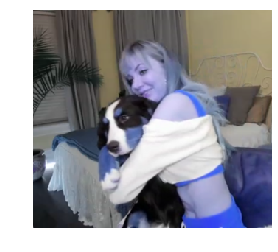

In [5]:
# getting test image for object detection
image = cv2.imread('/mnt/chromeos/GoogleDrive/MyDrive/Datasets/baby.PNG')
# displaying generic test image with no detection and labels
plt.imshow(image)
plt.axis('off')
plt.show()

In [6]:
# Constructs a Faster R-CNN model with a ResNet-50-FPN backbone
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [7]:
summary(model)

Layer (type:depth-idx)                                  Param #
FasterRCNN                                              --
├─GeneralizedRCNNTransform: 1-1                         --
├─BackboneWithFPN: 1-2                                  --
│    └─IntermediateLayerGetter: 2-1                     --
│    │    └─Conv2d: 3-1                                 (9,408)
│    │    └─FrozenBatchNorm2d: 3-2                      --
│    │    └─ReLU: 3-3                                   --
│    │    └─MaxPool2d: 3-4                              --
│    │    └─Sequential: 3-5                             (212,992)
│    │    └─Sequential: 3-6                             1,212,416
│    │    └─Sequential: 3-7                             7,077,888
│    │    └─Sequential: 3-8                             14,942,208
│    └─FeaturePyramidNetwork: 2-2                       --
│    │    └─ModuleList: 3-9                             984,064
│    │    └─ModuleList: 3-10                            2,360,320
│    

In [8]:
# setting the model in evaluation mode(lol no training)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
# transforming image to tensor
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])
nn_input = transform(image)
#getting output from the model
output = model([nn_input])

In [21]:
# random colors for each class of the COCO dataset
colors = np.random.uniform(0,255, size=(len(classes), 3))

In [22]:
# iterating over the network outputs for all boxes
for box, box_class, score in zip(output[0]['boxes'].detach().numpy(), 
                                output[0]['labels'].detach().numpy(),
                                output[0]['scores'].detach().numpy()):
    # filter the boxes by CI score(usually 0.5)
    if score > 0.5:
        # transform bounding box format to be 
        # top-left and bottom-right pixels of box (has to be integers)
        box = [(int(box[0]), int(box[1])), (int(box[2]), int(box[3]))]
        # selecting class color
        color = colors[box_class]
        # extracting class name
        class_name = classes[box_class]
        #drawing the bounding box
        cv2.rectangle(image, box[0], box[1],color=color, thickness=2)
        # displaying the box class label
        cv2.putText(img=image, text=class_name, org=box[0],
                    fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1, color=color, thickness=2)

In [23]:
cv2.imshow('Object detection', image)
cv2.waitKey()